In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import quantstats as qs

In [2]:
btc_data = pd.read_csv('BITSTAMP_BTCUSD, 1D_62909.csv')
btc_data['time'] = btc_data['time'].apply(lambda x: x.replace('T08:00:00+08:00', ''))
btc_data.set_index('time', inplace=True)
btc_data['HV'] = btc_data['HV'] * 0.01


IV = pd.read_csv('deribit-metrics.csv')
IV['DateTime'] = IV['DateTime'].apply(lambda x: x.replace(' 00:00:00', ''))
IV.set_index('DateTime', inplace=True)
IV['BTC Volatility Index (DVOL)'] = IV['BTC Volatility Index (DVOL)'] * 0.01

In [3]:
backtest_period = ['2021-03-24', '2022-03-24']
ftest_period = ['2022-03-25', '2023-06-15']

In [4]:
HV_backtest_data = btc_data.loc[backtest_period[0]:backtest_period[1]]['HV']
HV_forward_data = btc_data.loc[ftest_period[0]:ftest_period[1]]['HV']

IV_backtest_data = IV.loc[backtest_period[0]:backtest_period[1]]['BTC Volatility Index (DVOL)']
IV_forward_data = IV.loc[ftest_period[0]:ftest_period[1]]['BTC Volatility Index (DVOL)']

In [11]:
def BB(data, rolling_window, std_multiplier):
    SMA = data.rolling(window=rolling_window).mean()
    std = data.rolling(window=rolling_window).std()
    lower_bound = SMA - std_multiplier*std
    upper_bound = SMA + std_multiplier*std
    
    return SMA, lower_bound, upper_bound

In [22]:
def VRP_BB_bound(df):
    
    df.index = pd.to_datetime(df.index)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['BTC Volatility Index (DVOL)'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['BTC Volatility Index (DVOL)']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    profit = close_price - open_price
    freq = len(profit)
    holding = close_date - open_date

    if freq != 0:   
        winning_rate = len(profit[profit > 0]) / freq
        holding_median = np.median(holding).days
        profit_median = np.mean(profit)
        
    else: 
        winning_rate = np.nan
        holding_median = np.nan
        profit_median = np.nan
        
    return winning_rate, freq, holding_median, profit_median

In [34]:
# forward_test 
rolling_window_list = [7]
std_multiplier_list = [1.25]
winning_rate_list = []

VRP = IV_forward_data-HV_forward_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_forward_data, IV_forward_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [35]:
result_df

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
0,7,1.25,0.633333,30,4,0.009987


In [46]:
def VRP_BB_bound_sharpe(df):
    
    df.index = pd.to_datetime(df.index)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['BTC Volatility Index (DVOL)'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['BTC Volatility Index (DVOL)']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    pct_return = pd.DataFrame((close_price - open_price)/open_price)
    sharpe_ratio = qs.stats.sharpe(pct_return, periods=365)
    freq = len(pct_return)

    if freq == 0:
        sharpe_ratio = np.nan
        
    return sharpe_ratio

Text(0.5, 1.0, 'Sharpe_ratio')

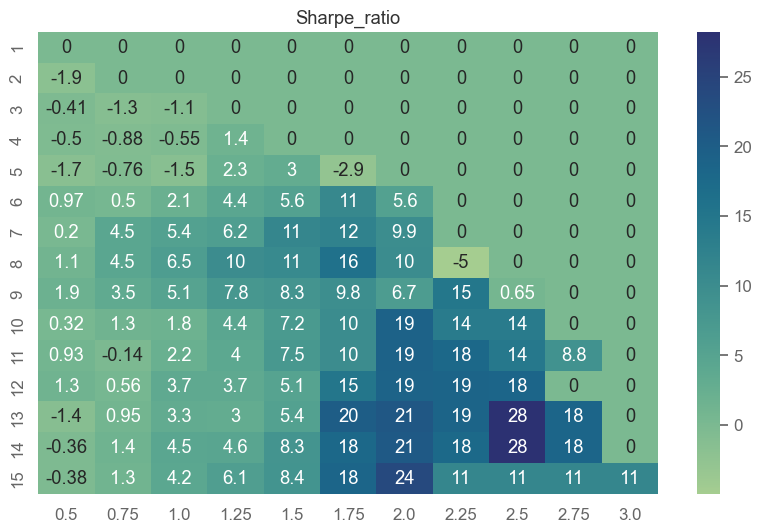

In [47]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

VRP = IV_forward_data-HV_forward_data
VRP = VRP.rename('VRP')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_forward_data.index = pd.to_datetime(HV_forward_data.index)
        HV_forward_data.index = [time.strftime('%Y-%m-%d') for time in HV_forward_data.index]
        df = pd.concat([HV_forward_data, IV_forward_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        sharpe_ratio = VRP_BB_bound_sharpe(df)
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})
        
ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')

In [7]:
HV_backtest_data

time
2021-03-24    0.869319
2021-03-25    0.871745
2021-03-26    0.884891
2021-03-27    0.884960
2021-03-28    0.865428
                ...   
2022-03-20    0.759379
2022-03-21    0.757358
2022-03-22    0.710061
2022-03-23    0.702797
2022-03-24    0.700894
Name: HV, Length: 366, dtype: float64

In [6]:
IV_backtest_data

DateTime
2021-03-24    0.8052
2021-03-25    0.8725
2021-03-26    0.8022
2021-03-27    0.7781
2021-03-28    0.7820
               ...  
2022-03-20    0.7130
2022-03-21    0.7133
2022-03-22    0.7089
2022-03-23    0.6950
2022-03-24    0.6543
Name: BTC Volatility Index (DVOL), Length: 366, dtype: float64

In [8]:
HV_SMA = HV_backtest_data.rolling(window=30).mean()
IV_SMA = IV_backtest_data.rolling(window=30).mean()

VRP_SMA = IV_SMA - HV_SMA

In [9]:
def VRP_SMA_BB_bound(df):
    
    df.index = pd.to_datetime(df.index)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP_SMA'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['BTC Volatility Index (DVOL)'])
            open_position = True

        if (row['VRP_SMA'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['BTC Volatility Index (DVOL)']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    profit = close_price - open_price
    freq = len(profit)
    holding = close_date - open_date

    if freq != 0:   
        winning_rate = len(profit[profit > 0]) / freq
        holding_median = np.median(holding).days
        profit_median = np.mean(profit)
        
    else: 
        winning_rate = np.nan
        holding_median = np.nan
        profit_median = np.nan
        
    return winning_rate, freq, holding_median, profit_median

In [17]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100
winning_rate_list = []

HV_SMA = HV_backtest_data.rolling(window=30).mean()
IV_SMA = IV_backtest_data.rolling(window=30).mean()
VRP_SMA = IV_SMA - HV_SMA

VRP_SMA = VRP_SMA.rename('VRP_SMA')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP_SMA, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP_SMA], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_SMA_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [18]:
result_df.sort_values(by='Freq', ascending=False)

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
11,2,0.50,0.466667,15,5.0,-0.016073
23,3,0.75,0.538462,13,5.0,-0.011577
22,3,0.50,0.538462,13,5.0,-0.011577
24,3,1.00,0.500000,12,5.0,-0.014033
33,4,0.50,0.666667,12,6.0,-0.013267
...,...,...,...,...,...,...
43,4,3.00,NaN,0,NaN,NaN
42,4,2.75,NaN,0,NaN,NaN
41,4,2.50,NaN,0,NaN,NaN
40,4,2.25,NaN,0,NaN,NaN


In [19]:
def VRP_SMA_BB_bound_sharpe(df):
    
    df.index = pd.to_datetime(df.index)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP_SMA'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['BTC Volatility Index (DVOL)'])
            open_position = True

        if (row['VRP_SMA'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['BTC Volatility Index (DVOL)']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    pct_return = pd.DataFrame((close_price - open_price)/open_price)
    sharpe_ratio = qs.stats.sharpe(pct_return, periods=365)
    freq = len(pct_return)

    if freq == 0:
        sharpe_ratio = np.nan
        
    return sharpe_ratio

Text(0.5, 1.0, 'Sharpe_ratio')

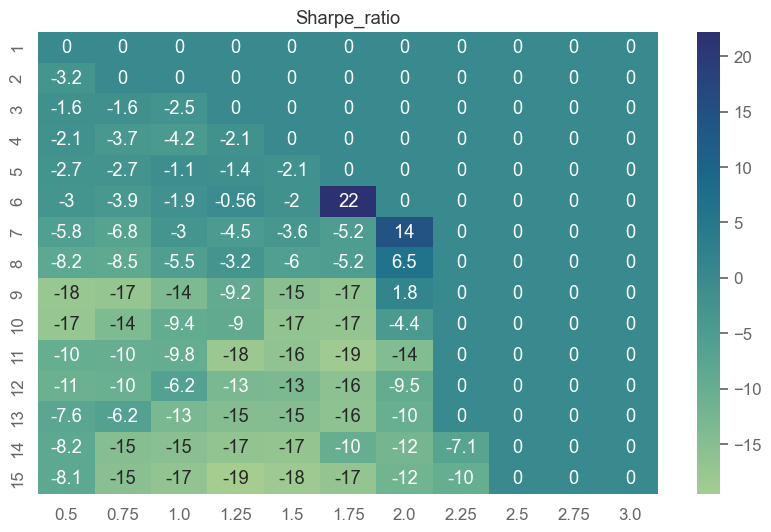

In [22]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

HV_SMA = HV_backtest_data.rolling(window=30).mean()
IV_SMA = IV_backtest_data.rolling(window=30).mean()
VRP_SMA = IV_SMA - HV_SMA

VRP_SMA = VRP_SMA.rename('VRP_SMA')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP_SMA, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP_SMA], axis=1)
        
        sharpe_ratio = VRP_SMA_BB_bound_sharpe(df)
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})
        
ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')